# Analysis of monkey experiments
**Copyright 2023 (c) Naomi Chaix-Echel & Nicolas P Rougier**  
Released under a BSD 2-clauses license

## Common packages / functions

In [1]:
%run "00-common.ipynb"

## Load data

In [2]:
# dataset = "RSTB"
dataset = "data"

data_file = f"./data/{dataset}-processed.csv"
results_json_file = f"./results/{dataset}-decision-fits.json"
results_figure_file = f"./figures/{dataset}-decision-fits.pdf"

data = pd.read_csv(data_file, parse_dates=["date"])
subject_ids = data['subject_id'].unique()
valid_ids, reject_ids = filter_subjects(data)
task_ids = list(range(1,8))

## Decision fit 

Considering the function

$
\begin{align}
p(x) = \frac{1}{1-e^{\mu(x-x_0)}}
\end{align}
$

we aim at fitting subjects response to measure their willingness to choose one option over the other. To do so, we compute the mean response when presented with two options (x1,p1) and (x2,p2) for every couples in a given task and we fit those points with the function above. For tasks 1 to 5, we consider right / left option while for tasks 6 and 7, we consider riskiest / safest options.

In [3]:
def sigmoid(x, mu, x0):
    """ Sigmoid """
    
    return 1 / (1 + np.exp(-mu * (x - x0)))


In [4]:
def fit_sigmoid(subject_id, task_id):
    """ Fit decision of SUBJECT_ID for TASK_ID
    
        Return the mu and x0 parameters for the sigmoid.
    """
    
    trials = select_trials(data, subject_id, task_id)
    condition, outcome = get_task_description(task_id)
    
    # Left stimuli
    P_left = np.array(trials['P_left'])
    V_left = np.array(trials['V_left'])
    EV_left = P_left * V_left

    # Right stimuli
    P_right = np.array(trials['P_right'])
    V_right = np.array(trials['V_right'])
    EV_right = P_right * V_right

    D = EV_right - EV_left
    R = np.array(trials['response'])
    
    if condition == Condition.tradeoff:
        # For riskiest and safest, we don't care about the sign of the reward
        # because tradeoff condition has been designd such that the higher prob
        # means safest (lower gain or lower loss) while the lower prob means
        # riskiest (higher gain or higher loss)
        L = (P_left < P_right) 
        D = np.where(L, -D, D)
        R = np.where(L, 1-R, R)
        
    X, Y = np.unique(D), []
    for x in X:
        I = np.argwhere(D == x)
        Y.append(R[I].sum()/len(I))
    
    p_opt, p_cov = curve_fit(f=sigmoid, xdata=X, ydata=Y, maxfev=10000)    
    return p_opt[0], p_opt[1], X, Y

## Compute sigmoid fits for all valid individuals and trial types

<div class="alert alert-block alert-warning">
<b>Warning:</b> This takes a few seconds</div>

<div class="alert alert-block alert-warning">
<b>Warning:</b> Left/Right bias is not taken into account and it is not clear how to take it into account</div>


In [5]:
sigmoid_fits = {}
total = len(valid_ids)*len(task_ids)

with tqdm(total=total) as progress:
    for subject_id in valid_ids:
        sigmoid_fits[subject_id] = {}
        for task_id in task_ids:
            fit = fit_sigmoid(subject_id, task_id)            
            sigmoid_fits[subject_id][task_id] = fit
            progress.update()

  0%|          | 0/98 [00:00<?, ?it/s]

## Save results

In [6]:
fits = {}
for subject_id in sigmoid_fits.keys():
    fit = sigmoid_fits[subject_id]
    for task_id in fit.keys():
        key = "%s-%d" % (subject_id, task_id)
        fits[key] = sigmoid_fits[subject_id][task_id][:2]

with open(results_json_file, "w") as file:
    json.dump(fits, file, indent=4)

## Plot all individuals and trial types

In [7]:
def get_task_color(task_id):
    """Color based on task outcome"""        
    
    colors = { Outcome.gain : "C0",
               Outcome.loss : "C1",
               Outcome.both : "black" }
    condidition, outcome = get_task_description(task_id)
    return colors[outcome]

def get_task_xlabel(task_id):
    """X label based on task condition"""        
    
    labels = { Condition.same_p   : "$EV_{right} - EV_{left}$",
               Condition.same_v   : "$EV_{right} - EV_{left}$",
               Condition.tradeoff : "$EV_{riskiest} - EV_{safest}$" }
    condition, outcome = get_task_description(task_id)
    return labels[condition]

def get_task_ylabel(task_id):
    """Y label based on task condition"""        
    
    labels = { Condition.same_p   : "p(choose right)",
               Condition.same_v   : "p(choose right)",
               Condition.tradeoff : "p(choose riskiest)" }
    condition, outcome = get_task_description(task_id)
    return labels[condition]

def get_task_title(task_id):
    
    titles = { Condition.same_p   : "Same probabilities",
               Condition.same_v   : "Same values",
               Condition.tradeoff : "Risky" }
    gains = { Outcome.gain : "gain",
              Outcome.loss : "loss",
              Outcome.both : "both" }

    condition, outcome = get_task_description(task_id)
    return titles[condition] + " (%s)" % gains[outcome] 


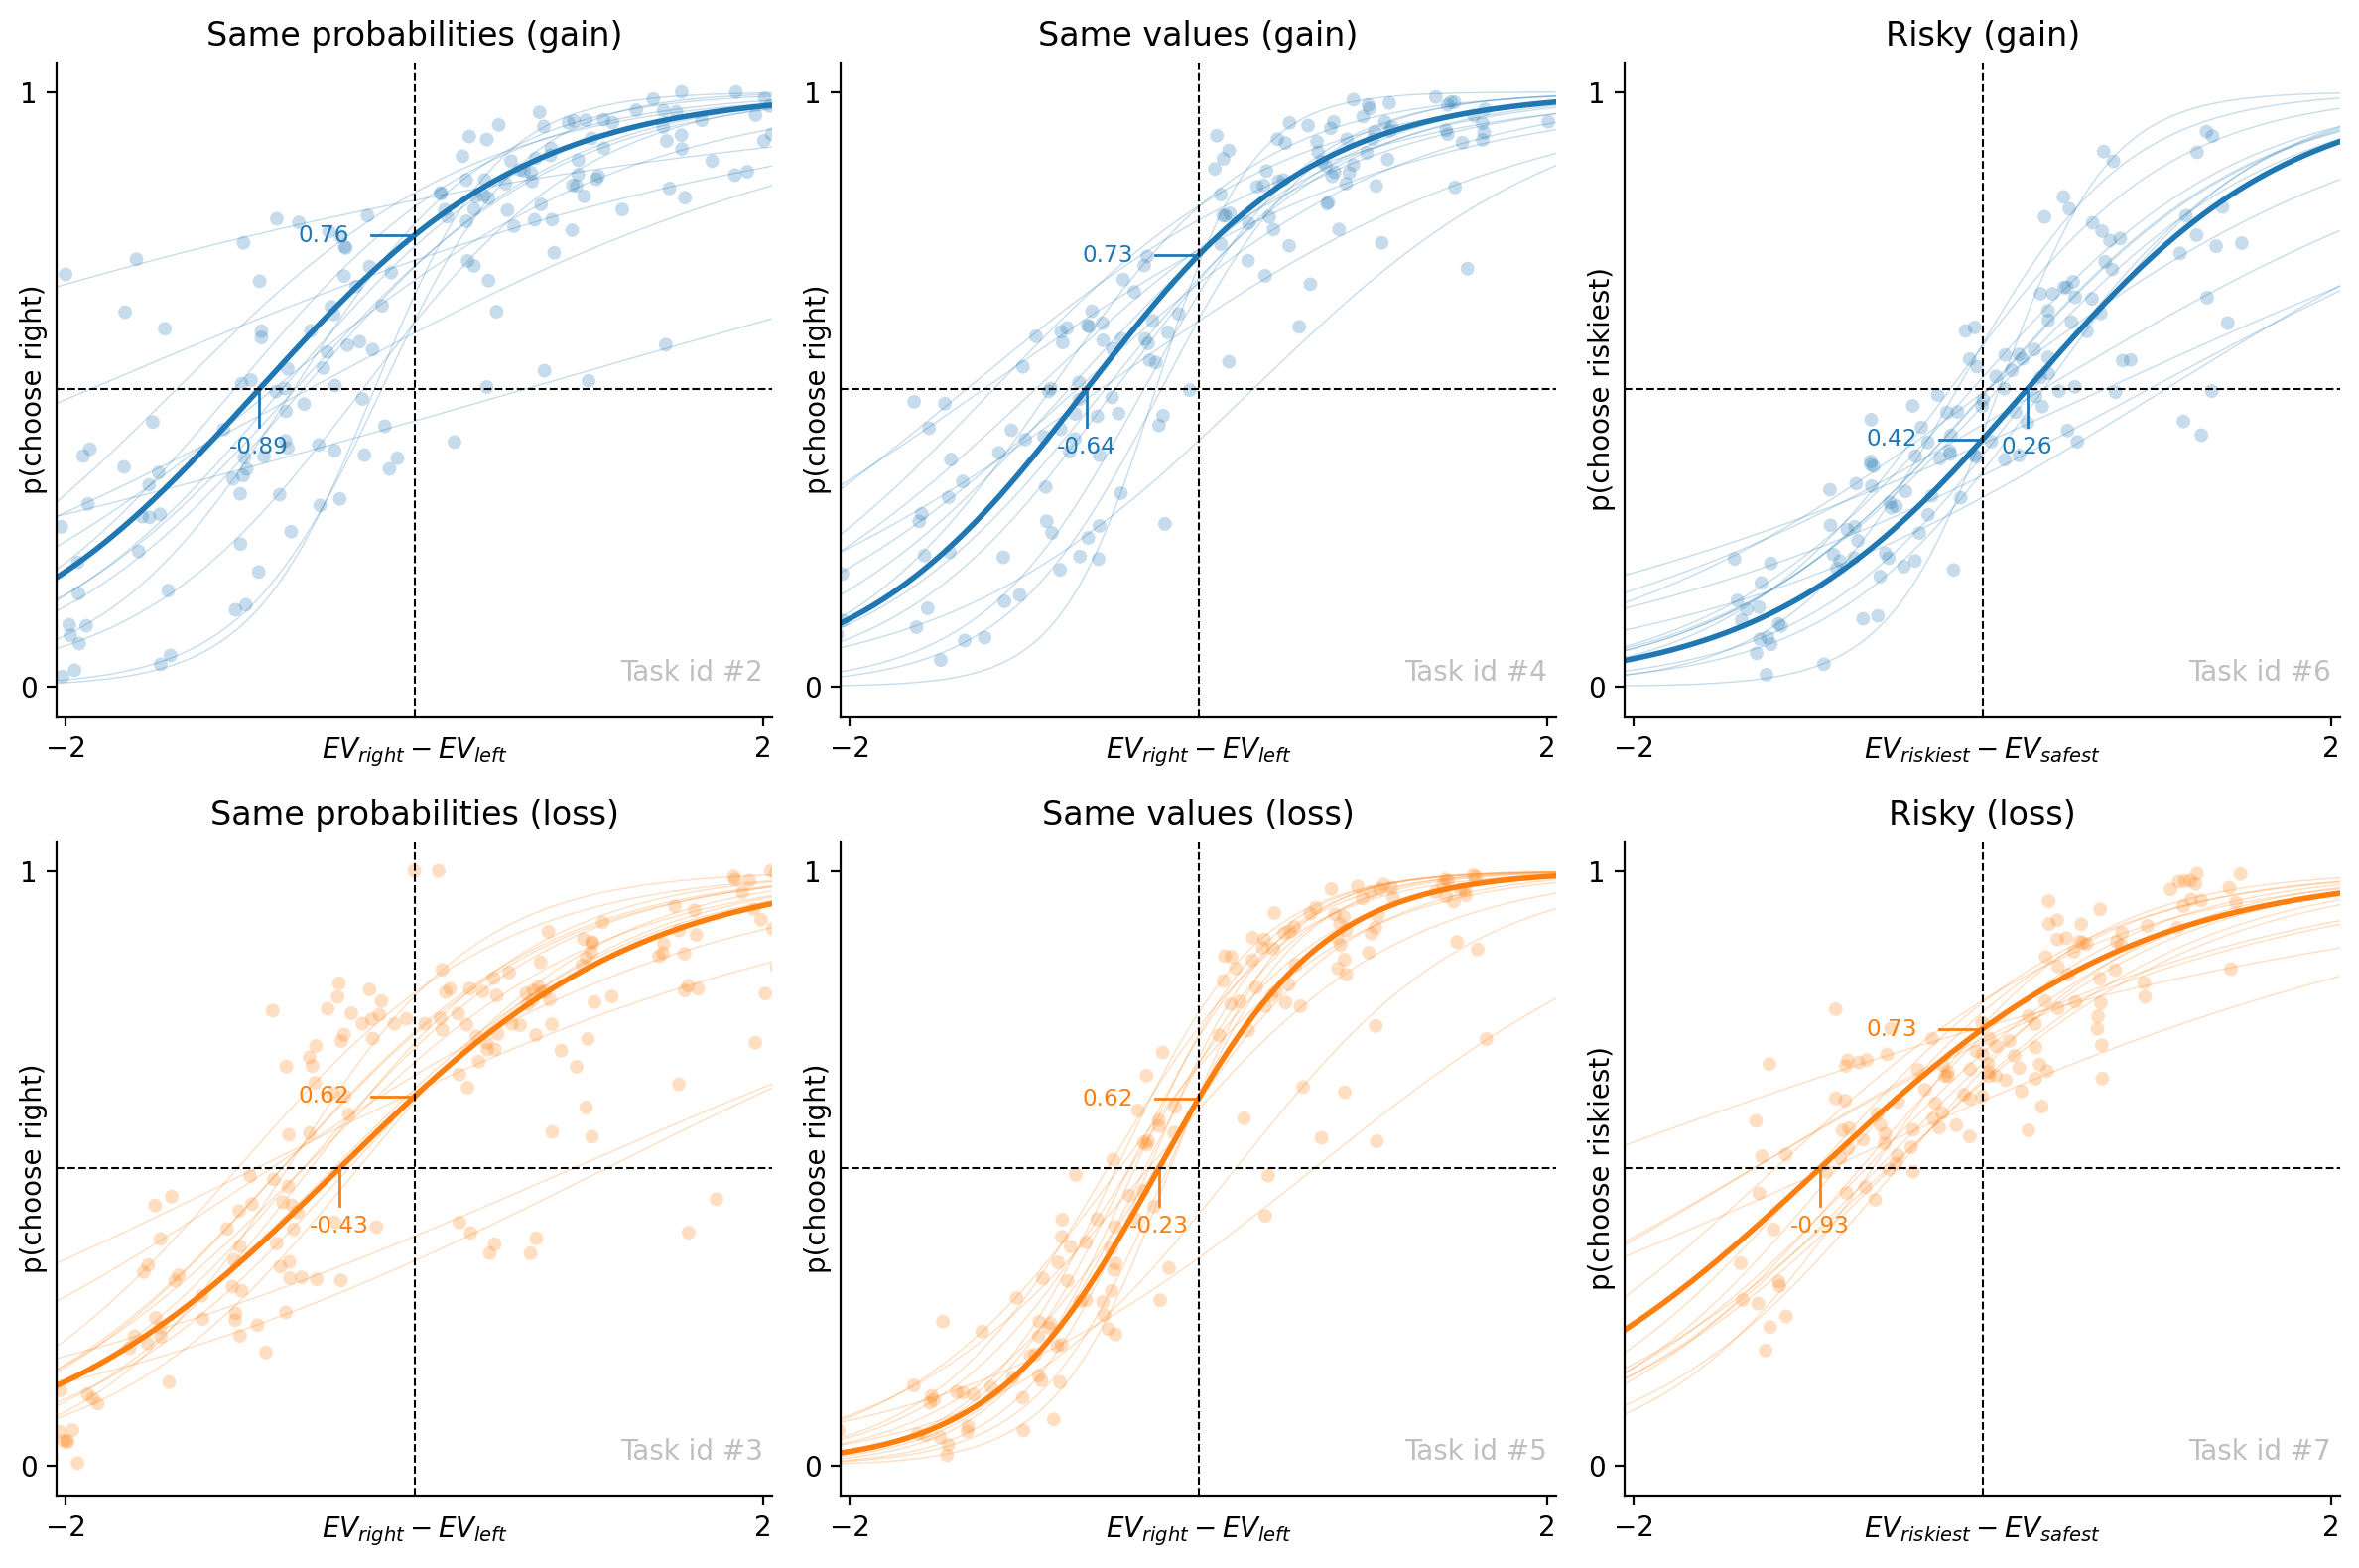

In [ ]:
# The mean fit is the sigmoid whose mu/x0 are the mean of individual fits

fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(12, 8), dpi=200)

EV_min = data["V_left"].min()*data["P_left"].min()
EV_max = data["V_left"].max()*data["P_left"].max()
xmin, xmax = EV_min-EV_max, EV_max - EV_min
X = np.linspace(xmin, xmax, 10000)

outcomes = [Outcome.gain, Outcome.loss]
conditions = [Condition.same_p, Condition.same_v, Condition.tradeoff]

for i, outcome in enumerate(outcomes):
    for j, condition in enumerate(conditions):
    
        task_id = get_task_id(condition, outcome)
        color = get_task_color(task_id)
        xlabel = get_task_xlabel(task_id)
        ylabel = get_task_ylabel(task_id)
        title = get_task_title(task_id)
        ax = axs[i,j]
    
        x0_mean, mu_mean, n = 0, 0, 0
        for subject_id in valid_ids:
            mu, x0, X_fit, Y_fit = sigmoid_fits[subject_id][task_id]
            
            # We reject fits whose x0 is twice outside bounds
            if 2*xmin < x0 < 2*xmax:
                x0_mean += x0
                mu_mean += mu
                n += 1
                ax.plot(X, sigmoid(X, mu, x0), color=color, alpha=0.25, lw=.5)   
                X_fit = X_fit + 0.1*np.random.normal(0, 1, X_fit.shape)
                ax.scatter(X_fit, Y_fit, s=25, facecolor=color, edgecolor="None", alpha=.25)                
            else:
                ax.plot(X, sigmoid(X, mu, x0), color="black", alpha=0.25, lw=.5, ls ="--")
                ax.scatter(X_fit, Y_fit, s=25, edgecolor=color, facecolor="None", alpha=.25)                
                
        x0_mean /= n
        mu_mean /= n
        ax.plot(X, sigmoid(X, mu_mean, x0_mean), color=color, alpha=1.0, lw=2)        

        dy = 0.25/4
        x = X[np.argmin(abs(sigmoid(X, mu_mean, x0_mean) - 0.5))] 
        ax.plot([x, x], [0.5-dy, 0.5], color=color, lw=1)
        ax.text(x, 0.5-1.25*dy, "%.2f" % x,
                ha="center", va="top", color=color, fontsize="small")
                        
        dx = 0.25
        y = float(sigmoid([0], mu_mean, x0_mean))
        ax.plot([-dx,0], [y,y], color=color, lw=1)
        ax.text(-1.5*dx, y, "%.2f" % y,
                ha="right", va="center", color=color, fontsize="small")
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(title)

        ax.set_ylim(-0.05, 1.05)
        ax.set_yticks([0,1])
        ax.set_ylabel(ylabel, labelpad=-10)
        
        ax.set_xlim(-2.05, 2.05)
        ax.set_xticks([-2, +2])
        ax.set_xlabel(xlabel, labelpad=-10)
        
        ax.text(2, 0, "Task id #%d" % task_id, ha="right", va="bottom", alpha=0.25)
        
        ax.axvline(0, ls='--', lw=0.75, color="black")
        ax.axhline(0.5, ls='--', lw=0.75, color="black")
plt.tight_layout()
plt.savefig(results_figure_file)